In [79]:
import datetime
import pandas as pd
import numpy as np
import sklearn #1.2.2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,auc, accuracy_score, f1_score, precision_score
from sklearn import model_selection
from sklearn import tree
from sklearn.utils import resample
from joblib import dump, load
import pickle
import time


In [80]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
import seaborn as sns

In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [83]:
from imblearn.over_sampling import SMOTE 

In [84]:
from scipy.stats import loguniform, uniform

KD_1 = loguniform.rvs(1e-3, 200, size=5000)
T0_1 = loguniform.rvs(1e-3, 200, size=5000)
thalf_1 = uniform.rvs(0.0167, 300, size=5000)
dff = pd.DataFrame(data=np.transpose([T0_1, thalf_1, KD_1]))
dff = dff.rename(columns = {0: 'T0', 1: 'thalf', 2: 'KD'})

## In Silico Synthetic Candidates

In [85]:
virtual_cand = pd.read_csv('examples/target_candLOG10000.csv')

## Fixed Dose 0.1 mg/kg

In [ ]:
## Fixed Dose 0.1 mg/kg
m_output_p1mgpkg_TsH = pd.read_csv('examples/PK_endpoint_0.1mg_q2w_human_Ts10000.csv')

## Fixed Dose 1 mg/kg


In [87]:
## Fixed Dose 1 mg/kg

m_output_1mgpkg_TsH = pd.read_csv('examples/PK_endpoint_1mg_q2w_human_Ts_last10000.csv')

## Fixed Dose 10 mg/kg


In [ ]:
m_output_10mgpkg_TsH = pd.read_csv('examples/PK_endpoint_10mg_q2w_human_Ts10000.csv')

## Fixed Charge at 1mg/kg (q2w)

In [ ]:
m_output_1mgpkg_p5_TsH = pd.read_csv('examples/PK_endpoint_1mg_+5_q2w_human_Ts10000.csv')
m_output_1mgpkg_m5_TsH = pd.read_csv('examples/PK_endpoint_1mg_-5_q2w_human_Ts10000.csv')

In [88]:
def pre_process(virtual_cand, m_output, dose):
    #virtual_cand = pre_label_input(virtual_cand)
    
    
    X = np.array(virtual_cand[['T0', 'thalf', 'KD']])

    y = m_output[["TO_plast"]]
    Y = np.array(y)
    
    Y[Y <= 50] = 0
    Y[(Y > 50) & (Y <= 90)] = 1
    Y[(Y > 90)] = 2
    
   

    smote = SMOTE() 
    x_smote, y_smote = smote.fit_resample(X, Y) 
  
    # print the features and the labels 
    print('x_smote:\n', x_smote) 
    print('y_smote:\n', y_smote) 
    
    df_smote = pd.DataFrame(x_smote)
    df_smote[3] = y_smote
    # df_smote.to_csv('results/balanced_data_10000_' + str(dose) +'.csv')
    

    count_2 = 0
    count_1 = 0
    count_0 = 0
    for i in y_smote:
        if i==1:
            count_1 =count_1 + 1
        elif i==2:
            count_2 = count_2 + 1
        else:
            count_0 = count_0 + 1
    print('class distribution, optimal ' + str(count_1) +' non-optimal ' + str(count_0))

    X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.1, random_state=42,stratify=y_smote)
    print('training data set ' +str(len(X_train)) + ' testing dataset ' + str(len(X_test)))
    return X, Y, X_train, X_test, y_train, y_test

In [89]:
def grid_opt(X_train, y_train):
    param_grid = {'min_samples_split': range(2,20,1), 
                  'max_depth': [5, 8, 10],
                  'min_samples_split': [2,3,5],
                  'splitter': ['best', 'random']
                 
             }
    tree_model = DecisionTreeClassifier(random_state=1024)
    grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, verbose=True)
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    print(model)
    return model

In [90]:
def grid_opt_RF(X_train, y_train):
    param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'criterion' :['gini', 'entropy'],
              'n_estimators': [100, 120, 150],
              'min_weight_fraction_leaf': [0,0.1,0.2,0.3,0.4,0.5]
             }
    tree_model = RandomForestClassifier(random_state=1024)
    grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, verbose=True)
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    print(model)
    return model


In [91]:
def DT_analysis(Model, X_train, y_train, n_trial):
    
   
    skf = StratifiedKFold(n_splits=5)
    #kf = KFold(n_splits=5)
    DTA_stratified = []

    for train_index, test_index in skf.split(X_train,y_train):
        X_tn, X_ts = X_train[train_index],X_train[test_index]
        y_tn, y_ts = y_train[train_index], y_train[test_index]
        Model = grid_opt(X_tn, y_tn)
        Model.fit(X_tn, y_tn)
        DTA_stratified.append(Model.score(X_ts, y_ts))
   
    pickle.dump(Model, open('results/multi-label classes/' + str(n_trial), 'wb'))
 
 
    #Model = pickle.load(open('results/DT_tree_analysis10mgpkg_Ts_mean', 'rb'))

    #dump(Model, 'results/' + str(n_trial) + '.joblib')
    
    return Model

In [92]:
# code snippet by Piotr Płoński 2021
# human-readable rules
from sklearn.tree import _tree

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
            
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
            ###
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
            
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
            
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
            
    return rules


In [93]:
def model_evaluate(dfx, dfy, dose):
  
    
    [X, Y, X_train, X_test, y_train, y_test] = pre_process(dfx, dfy,dose)
    
    model = DecisionTreeClassifier(criterion= 'gini', max_depth=5, min_samples_leaf= 1, min_samples_split=3, splitter= 'best', class_weight='balanced', random_state=42) # min_samples leaf and class weight?
   
    #model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=5, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', class_weight='balanced')
    #model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=42)

    
    Model = DT_analysis(model, X_train, y_train, 'DT_tree_analysis' + str(dose))
    print(Model)
  
    y_pred = Model.predict(X_test)
    #print(Model.get_n_leaves())
    
    df_pred = pd.DataFrame(X_test, columns=['T0', 'thalf','KD'])
    df_pred['y_test'] = y_test
    df_pred['y_pred'] = y_pred
    df_pred.to_csv('results/TestvPred' + str(dose) +'.csv')
    
    conf_matrix = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
    print(conf_matrix)
 
    report = classification_report(y_test,y_pred)
    print(report)
    with open('results/classification_report'+ str(dose) +'.txt', 'w') as f:
        f.write(report)
        f.close()

    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    #roc_auc = auc(false_positive_rate, true_positive_rate)
    #print(roc_auc)
    
    fig, ax = plt.subplots()
    for i in range(3):
        for j in range(3):
            c = conf_matrix[i][j]
            ax.text(j, i, str(c), va='center', ha='center', color='black', size=16)
        
    ax.matshow(conf_matrix, cmap=plt.cm.Blues) 
    ax.grid(False)
 
    fig.savefig("results/Confusion_Matrix_" + str(dose) + ".jpeg", dpi=300)
    
    #fig1, ax1 = plt.subplots()
    #plt.plot(false_positive_rate, true_positive_rate, '-', color='red')
    #plt.ylabel('true positive rate')
    #plt.xlabel('false positive rate')
    
    #fig1.savefig("mTPA_results/repeated scheme/ROC_curve_" + str(dose) + ".jpeg", dpi=300)
    
    
    #feature_n = ['Ts0', 'Tm0', 't1/2s', 't1/2m', 'KD_t']
    feature_n = ['T0', 'thalf', 'KD']
    
    fig2 = plt.figure(figsize=(30,30))
    f_ = tree.plot_tree(Model, 
                   feature_names=feature_n,  
                   class_names=["low", "medium", "high"],
                   filled=True, fontsize=10)
  
    fig2.savefig("results/decision_tree_plot_SMOTE_" + str(dose) +".jpeg", dpi=300)
    
    rules = get_rules(Model, feature_n, ["low", "medium", "high"])    
        
    return Model, rules, X_train, y_train, X_test, y_test, y_pred

In [56]:
def model_compare(dfx, dfy, dose):

    [X, Y, X_train, X_test, y_train, y_test] = pre_process(dfx, dfy,dose)
    
    modelDT = DecisionTreeClassifier(criterion = 'gini', max_depth=5, min_samples_leaf= 1, min_samples_split=3, splitter= 'best', class_weight='balanced', random_state=42)
    modelRF = RandomForestClassifier(n_estimators = 100, criterion='gini', max_depth=5, min_samples_split=3, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', class_weight='balanced', random_state=42)
    modelGB = GradientBoostingClassifier(n_estimators = 100, learning_rate=1.0, max_depth=5, random_state=42)

    #modelxgb =  xgb.XGBClassifier(objective='binary:logistic', n_estimators = 5, max_depth=5)
    
    ModelDT = DT_analysis(modelDT, X_train, y_train, 'DT_tree_analysis' + str(dose))
    ModelRF = DT_analysis(modelRF, X_train, y_train, 'DT_tree_analysis' + str(dose))
    ModelGB = DT_analysis(modelGB, X_train, y_train, 'DT_tree_analysis' + str(dose))
    
    models_comp = []
    models_comp.append(('DT', modelDT))
    models_comp.append(('RF', modelRF))
    models_comp.append(('GB', modelGB))
    
    with open('results/model_comp_'+ str(dose)+'.txt', 'w') as f:
  
        train_res = []

        names = []
        scoring = 'accuracy'
        f.write('Training Score: Accuracy \n')
        for name, model in models_comp:
            tic = time.time()
            skf = StratifiedKFold(n_splits=5) 
            cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=skf, scoring=scoring)
            train_res.append(cv_results)
            names.append(name)
            toc = time.time()
            msg = "%s: %f (%f) {%f} \n" % (name, cv_results.mean(), cv_results.std(), toc - tic)
            
            f.write(msg)
        
        train_res = []
        names = []
        f.write('Training Score: Precision \n')
        scoring = 'precision'
        for name, model in models_comp:
            
            skf = StratifiedKFold(n_splits=5) 
            cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=skf, scoring=scoring)
            train_res.append(cv_results)
            names.append(name)
            msg = "%s: %f (%f) \n" % (name, cv_results.mean(), cv_results.std())
        
            f.write(msg)
        
        train_res = []
        names = []
        f.write('Training Score: F1 \n')
        scoring = 'f1'
        for name, model in models_comp:
            skf = StratifiedKFold(n_splits=5) 
            cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=skf, scoring=scoring)
            train_res.append(cv_results)
            names.append(name)
            msg = "%s: %f (%f) \n" % (name, cv_results.mean(), cv_results.std())
            f.write(msg)
    
    
        
        estimatorF1 = []

        for curEstimator in range(100):
            estimatorF1.append([curEstimator,f1_score(y_test, ModelRF.estimators_[curEstimator].predict(X_test))])

            estimatorF1=pd.DataFrame(estimatorF1,columns=['estimatorNumber','F1-score'])
            estimatorF1.sort_values(inplace=True,by='F1-score',ascending=False)

            bestDecisionTree = ModelRF.estimators_[estimatorF1.head(1)['estimatorNumber'].values[0]]

        f.write('\n Testing Accuracy \n')
        
       
        
        ts = accuracy_score(y_test, ModelDT.predict(X_test))
        f.write('DT:' + str(ts) + '\n')
        ts = accuracy_score(y_test, bestDecisionTree.predict(X_test))
        f.write('RF:' + str(ts) + '\n')
        ts = accuracy_score(y_test, ModelGB.predict(X_test))
        f.write('GB:' + str(ts) + '\n')
        
        f.write('\n Testing F1-score \n')
        ts = f1_score(y_test, ModelDT.predict(X_test))
        f.write('DT:' + str(ts) + '\n')
        ts = f1_score(y_test, bestDecisionTree.predict(X_test))
        f.write('RF:' + str(ts) + '\n')
        ts = f1_score(y_test, ModelGB.predict(X_test))
        f.write('GB:' + str(ts) + '\n')
        
        
        f.write('\n Testing Precision \n')
        ts = precision_score(y_test, ModelDT.predict(X_test))
        f.write('DT:' + str(ts) + '\n')
        ts = precision_score(y_test, bestDecisionTree.predict(X_test))
        f.write('RF:' + str(ts) + '\n')
        ts = precision_score(y_test, ModelGB.predict(X_test))
        f.write('GB:' + str(ts) + '\n')
        

        f.close
    
    return ModelDT, bestDecisionTree, ModelGB

In [57]:
# dose = '0.1mgpkg_Tm_2max_smote_'

# [ModelDT, bestDecisionTree, ModelGB] = model_compare(virtual_cand_p1mgpkg_TmH, m_output_p1mgpkg_TmH, dose)

x_smote:
 [[2.42895356e+00 1.68990419e+01 5.24039200e-03]
 [4.96868161e+02 7.19088230e-02 1.15196559e-01]
 [5.57732181e+01 2.00502229e+02 1.53447505e+01]
 ...
 [2.69109921e+01 1.20959057e+01 7.13468067e-01]
 [9.52040805e+00 6.72342657e-01 2.12069103e+00]
 [6.06127758e+01 5.12782709e+01 3.66978173e+01]]
y_smote:
 [2. 0. 1. ... 1. 1. 1.]
class distribution, optimal 4190 non-optimal 4190
training data set 11313 testing dataset 1257
Fitting 5 folds for each of 18 candidates, totalling 90 fits
DecisionTreeClassifier(max_depth=10, random_state=1024)
Fitting 5 folds for each of 18 candidates, totalling 90 fits
DecisionTreeClassifier(max_depth=10, min_samples_split=3, random_state=1024)
Fitting 5 folds for each of 18 candidates, totalling 90 fits
DecisionTreeClassifier(max_depth=10, min_samples_split=3, random_state=1024)
Fitting 5 folds for each of 18 candidates, totalling 90 fits
DecisionTreeClassifier(max_depth=10, min_samples_split=3, random_state=1024)
Fitting 5 folds for each of 18 candi

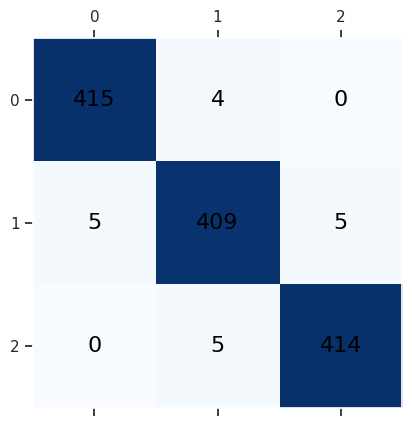

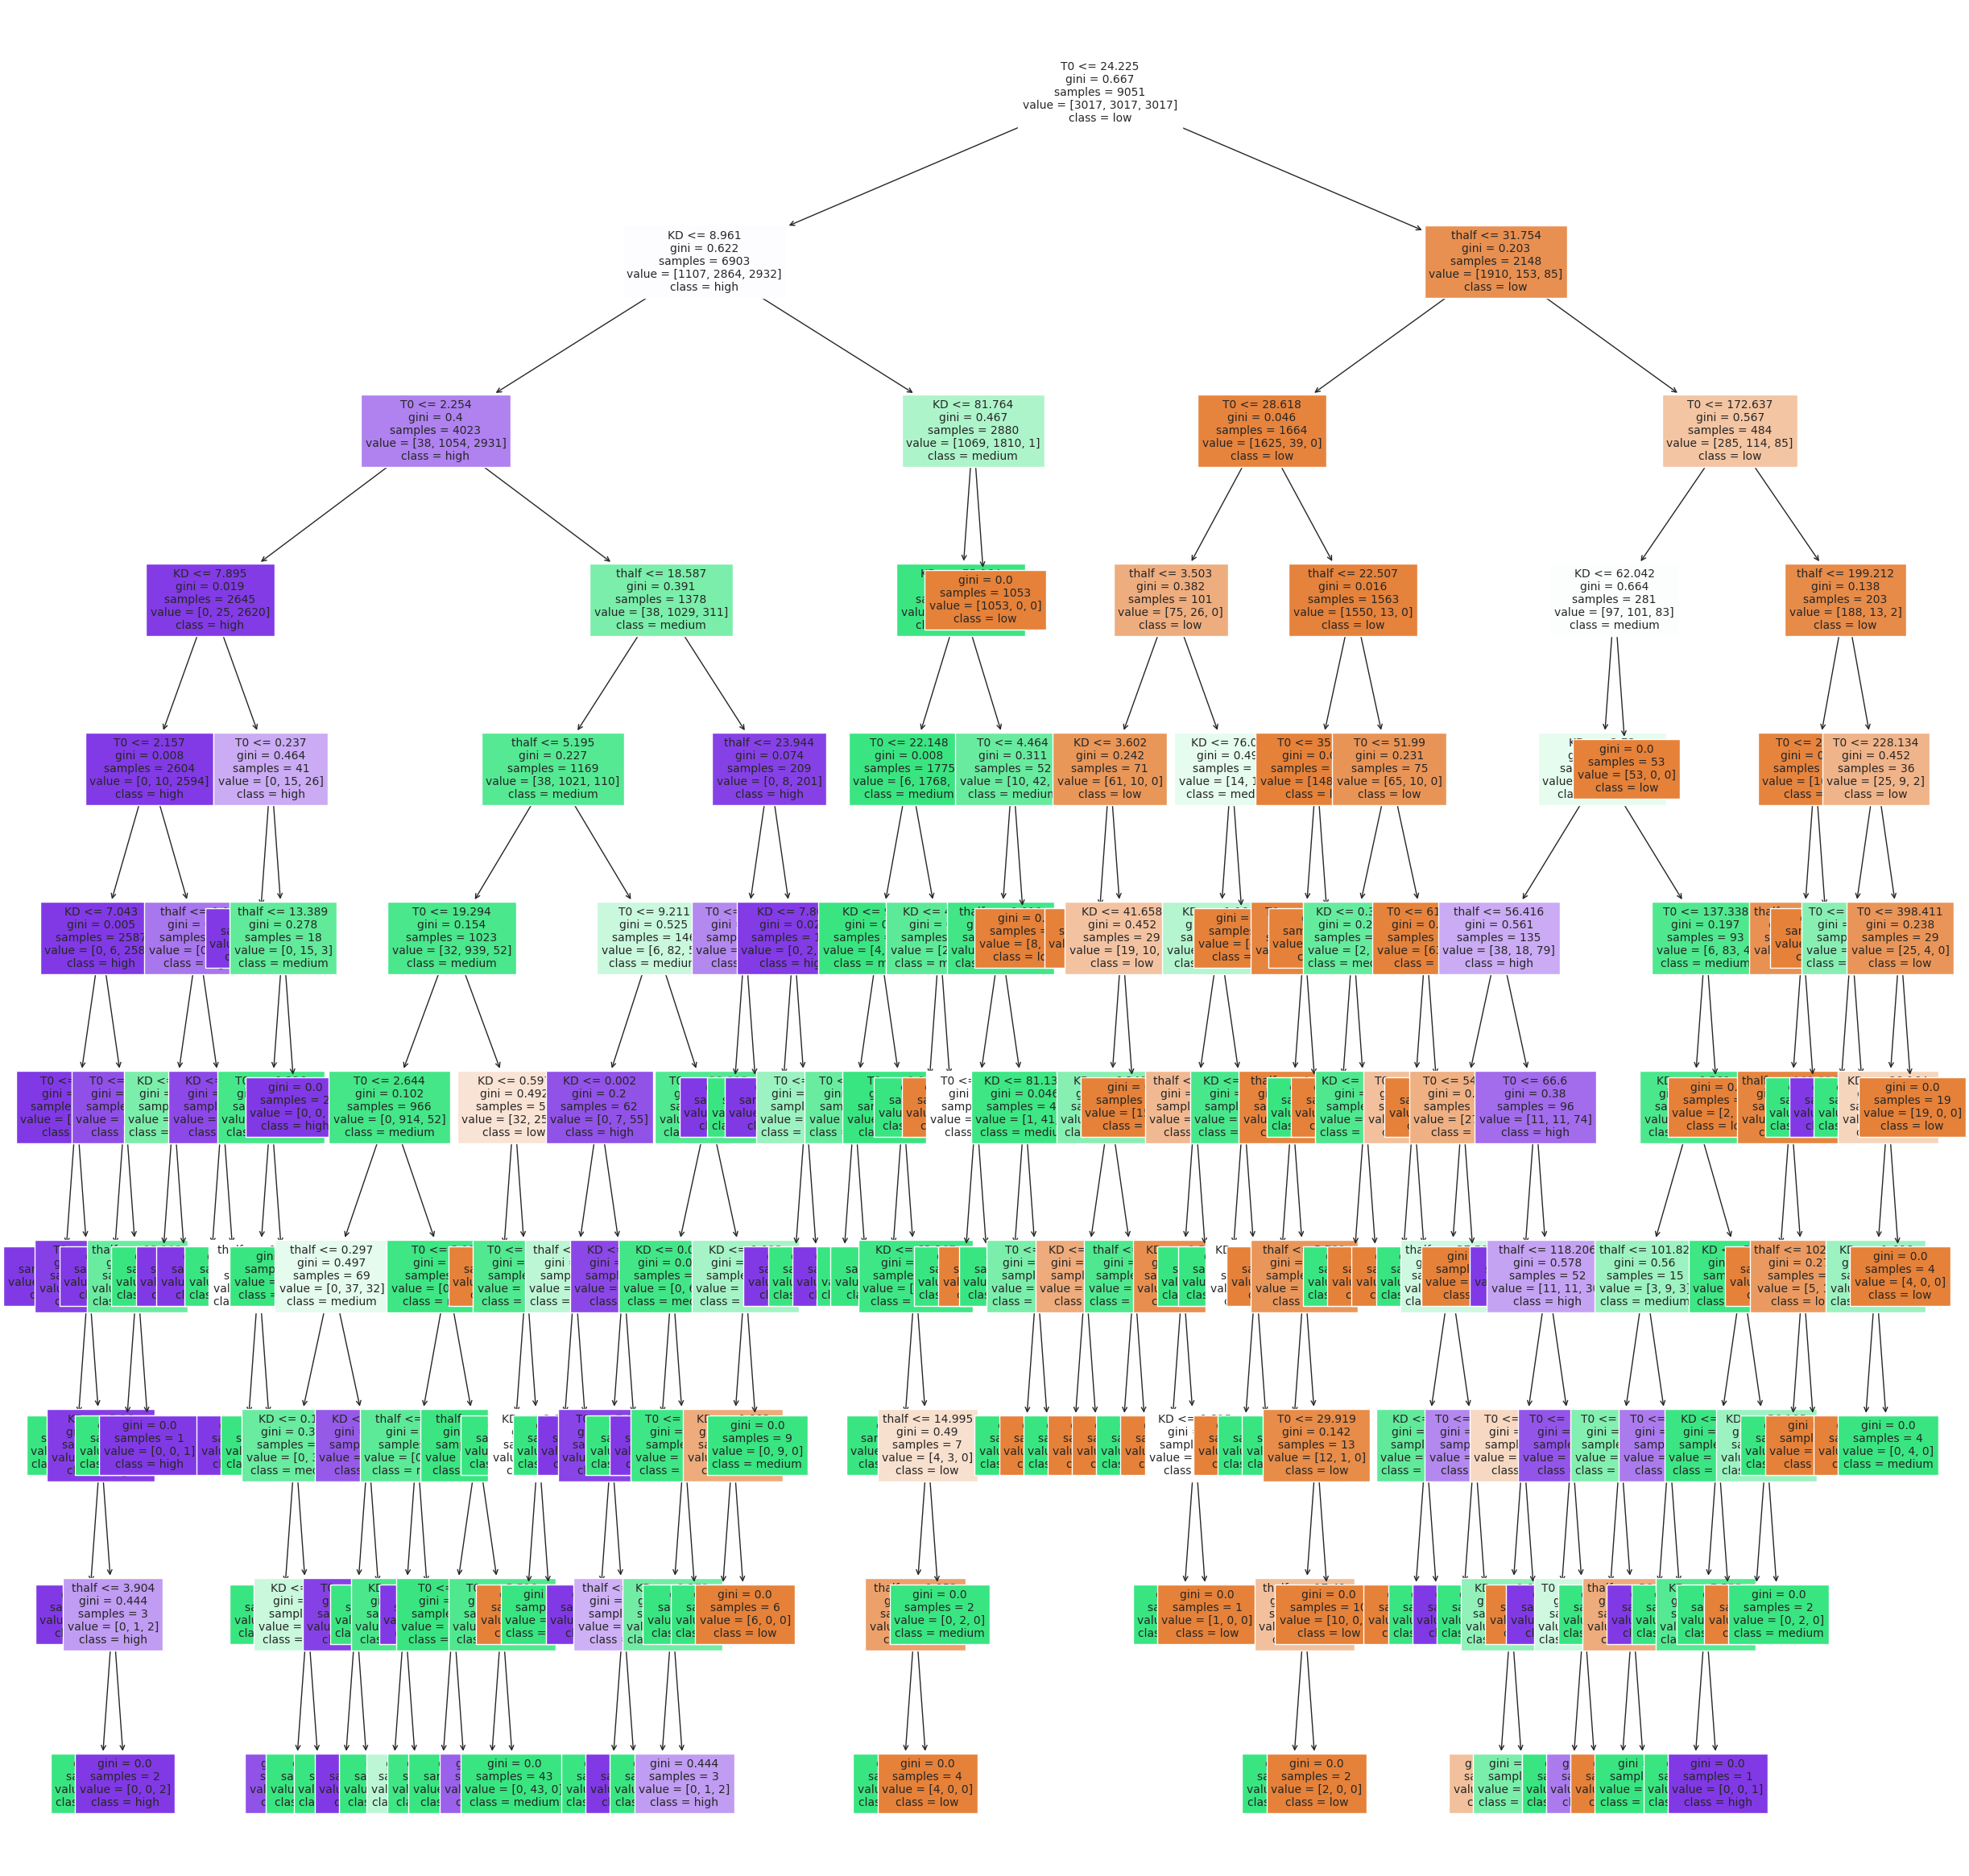

In [94]:
dose = '1mgpkg_q2w_Ts_plast_10000' 
[Model, rules, X_train, y_train, X_test, y_test, y_pred] = model_evaluate(virtual_cand, m_output_1mgpkg_TsH, dose)
with open('results/multi-label classes/DTrules_'+ str(dose)+'.txt', 'w') as f:
    for i in rules:
        f.write(i + '\n')

In [ ]:
for i in rules:
    if 'class: high' in i:
        print(i)

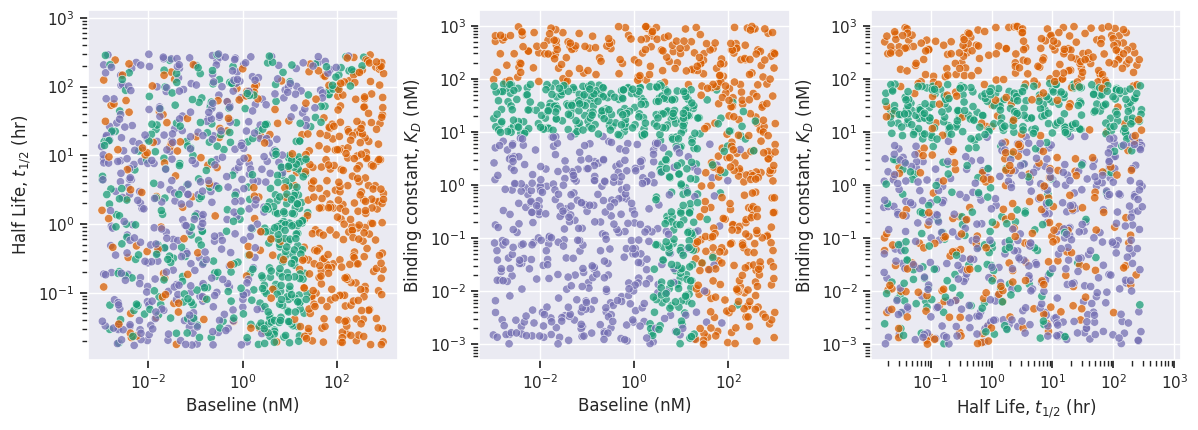

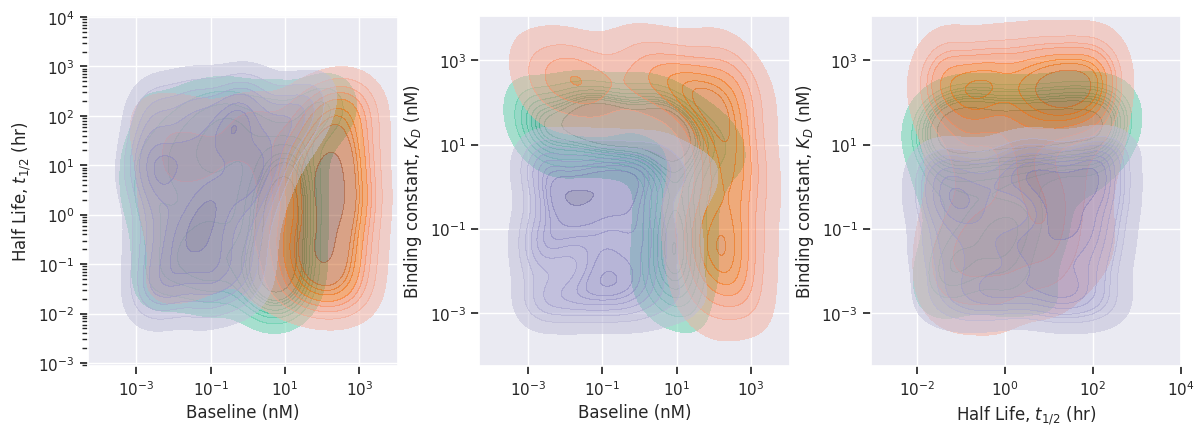

In [110]:
# set seaborn style

sns.set_style("white")

df1 = pd.DataFrame(X_test, columns = ['Baseline (nM)', 'Half Life, $t_{1/2}$ (hr)',  'Binding constant, $K_D$ (nM)'])
df1['pred_label'] = y_pred


target_names = ["low", "medium", "high"]

fig3 = plt.figure(figsize =(12,12))

for pairidx, pair in enumerate([['Baseline (nM)', 'Half Life, $t_{1/2}$ (hr)'], ['Baseline (nM)',  'Binding constant, $K_D$ (nM)'], ['Half Life, $t_{1/2}$ (hr)',  'Binding constant, $K_D$ (nM)']]): #

    sns.set_theme(rc={"xtick.bottom" : True, "ytick.left" : True})
    ax = plt.subplot(3,3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.25, pad=0.5)
    

    gpx = sns.scatterplot(data=df1[pair], x=pair[0], y=pair[1], hue=df1.pred_label, hue_order=[1,0,2], palette='Dark2', alpha=0.75) #, style=df1.pred_label)
    
    gpx.set_xlabel(pair[0])
    gpx.set_ylabel(pair[1])
    gpx.set_xscale("log")
    gpx.set_yscale("log")
    gpx.set_ylim([min(df1[pair[1]])-100, max(df1[pair[1]]) + 1000])
    gpx.set_xlim([min(df1[pair[0]])-100, max(df1[pair[0]]) + 1000])
    
    ax.get_legend().set_visible(False)


plt.show()

    
fig3.savefig('results/scatterplot' + str(dose) + '.jpeg', dpi=300)

fig4 = plt.figure(figsize=(12,12))
#sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})


for pairidx, pair in enumerate([['Baseline (nM)', 'Half Life, $t_{1/2}$ (hr)'], ['Baseline (nM)',  'Binding constant, $K_D$ (nM)'], ['Half Life, $t_{1/2}$ (hr)',  'Binding constant, $K_D$ (nM)']]): #
    
    sns.set_theme(rc={"xtick.bottom" : True, "ytick.left" : True})
    ax = plt.subplot(3, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.25, pad=0.5)
    gpx = sns.kdeplot(data=df1[pair], x=pair[0], y=pair[1], hue=df1.pred_label, fill=True, alpha=0.5,hue_order=[1,0,2], palette='Dark2', log_scale=True)
    gpx.set_ylim([min(df1[pair[1]])-100, max(df1[pair[1]]) + 10000])
    gpx.set_xlim([min(df1[pair[0]])-100, max(df1[pair[0]]) + 10000])
    gpx.set_xlabel(pair[0])
    gpx.set_ylabel(pair[1])
    ax.get_legend().set_visible(False)


plt.show()

fig4.savefig('results/kdeplot' + str(dose) + '.jpeg', dpi=300)

df3 = df1[df1['pred_label']==1]